# Olfactory search with finite-state controllers

Description:
Optimization of the FSC model for the plume tracking task

----------------------------------------------------------------------------

Author: kyrellverano
LastUpdate: 2023-11-16

----------------------------------------------------------------------------

Reference: https://doi.org/10.1101/2023.03.10.532037

----------------------------------------------------------------------------

Contributors: 

    LuisAlfredoNu | <luis.alfredo.nu@gmail.com> | LastUpdate: 2024-01-08

----------------------------------------------------------------------------

In [1]:
import sys
import json
import os
import time

import numpy as np
import itertools as it
from scipy.special import softmax
from scipy import interpolate

import matplotlib.pyplot as plt

import importlib
# Path to the comm folder
file_path = '../Comm/'
sys.path.append(file_path)
import utils as utils
import fsc_visualize_tools as fsc_visual

importlib.reload(utils)
importlib.reload(fsc_visual)

# ----------------------------------------------------------------------------
# Select the method to solve the optimization problem
method = 'direct'
# method = 'iter'

# ----------------------------------------------------------------------------
# Select the library to solve the linear system 
lib_solve_linear_system = 'scipy'
# lib_solve_linear_system = 'petsc'
# lib_solve_linear_system = 'cupy'

solver = utils.solver_opt()
solver.set_lib_solver(lib_solve_linear_system)

# ----------------------------------------------------------------------------
# Select the device to run the code
device = 'cpu'
# device = 'gpu'

# ----------------------------------------------------------------------------
# Set the output folder name
output_folder = 'opt'

# ----------------------------------------------------------------------------
# Set the precision for printing
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=1000)

# ----------------------------------------------------------------------------
# Fix the seed for reproducibility
# np.random.seed(33+33+33)


Using scipy solver


## Set the parameters of the FSC model

In [2]:
fsc_param = utils.parameters()

### Agent's parameters

In [3]:
# Memory of the agent.
fsc_param.agent.M = 4
# Number of observations of the agent.
fsc_param.agent.O = 2
# Maximum number of observations of the agent.
fsc_param.agent.max_obs = 6

# Number of actions of the agent.
fsc_param.agent.A = 6
# List of the actions of the agent.
fsc_param.agent.actions_move = [[1, 0], [-1, 0], [0, -1], [0, 1], [1,-1], [1,1], [-1,-1], [-1,1]]
# List of the names of the actions of the agent.
fsc_param.agent.actions_name = ['up', 'down', 'left', 'right', 'u-l', 'u-r', 'd-l', 'd-r']

# Handler of the actions of the agent.
fsc_param.agent.act_hdl = utils.AgentActions(fsc_param.agent.A)
for i in range(fsc_param.agent.A):
    fsc_param.agent.act_hdl.set_action(i, fsc_param.agent.actions_move[i], fsc_param.agent.actions_name[i])

# Number of actions times the memory of the agent.
fsc_param.agent.AxM = fsc_param.agent.A * fsc_param.agent.M

# Learning rate of the agent.
fsc_param.agent.lr_th = 0.01 # or 'auto'
if fsc_param.agent.lr_th == 'auto':
    # Learning rate schedule of the agent.
    # List of the learning rates of the agent.
    fsc_param.agent.lr_val = [0.1, 0.01, 0.001, 0.0001]
    # List of the fraction time of change of the learning rates.
    fsc_param.agent.lr_time_frac = [0.25, 0.50, 0.75, 1.0]

# Discount factor of the agent.
fsc_param.agent.gamma = 0.99975
# Cost of moving of the agent.
fsc_param.agent.cost_move = 1.0 - fsc_param.agent.gamma
# Reward of finding the source of the agent.
fsc_param.agent.reward_find = 0.0


### Environment's parameters

In [4]:
# Size of the environment in the x direction.
fsc_param.env.Lx = 30
# Size of the environment in the y direction.
fsc_param.env.Ly = 50
# Size of the environment.
fsc_param.env.L = fsc_param.env.Lx * fsc_param.env.Ly

# Position of the source in the x direction.
fsc_param.env.Lx0 = 15.0
# Position of the source in the y direction.
fsc_param.env.Ly0 = 40.0

# Range of the agent to find the source.
fsc_param.env.find_range = 2.1
# Standard deviation of the gaussian of the source.
fsc_param.env.sigma = 4


# Factor to scale the environment size
fsc_param.env.factor_dim = 1.0
if fsc_param.env.factor_dim != 1.0:
    fsc_param.env.Lx = int(fsc_param.env.Lx * fsc_param.env.factor_dim)
    fsc_param.env.Ly = int(fsc_param.env.Ly * fsc_param.env.factor_dim)
    fsc_param.env.L = fsc_param.env.Lx * fsc_param.env.Ly
    fsc_param.env.Lx0 = fsc_param.env.Lx0 * fsc_param.env.factor_dim
    fsc_param.env.Ly0 = fsc_param.env.Ly0 * fsc_param.env.factor_dim
    fsc_param.env.find_range = fsc_param.env.find_range * fsc_param.env.factor_dim


### Plume's parameters

In [5]:
# Use experimental data for the plume.
fsc_param.plume.experimental = True

# Parameters for experimental data.
# Coarse of the plume.
fsc_param.plume.coarse = 0
# Threshold of the plume.
fsc_param.plume.dth = 5
# Symmetry of the plume.
fsc_param.plume.symmetry = 1
# Replica of the plume.
fsc_param.plume.replica = 0

# Parameters for model plume
# Statistics of the plume. "Bernoulli" or "Poisson"
fsc_param.plume.plume_stat = 'Poisson'
# Diffusion coefficient of the plume.
fsc_param.plume.D = 50.0
# Wind speed of the plume.
fsc_param.plume.V = 100.0
# Time of the plume.
fsc_param.plume.tau = 2000.0
# Beta of the plume.
fsc_param.plume.beta = 5
# Factor to adjust the size of the plume.
fsc_param.plume.adjust_factor = 1.0 # or "auto"
if fsc_param.plume.adjust_factor == "auto":
    fsc_param.plume.adjust_factor = fsc_param.env.Lx / 75



### Optimization's parameters

In [6]:
# Tolerance of the eta convergence.
fsc_param.optim.tol_eta = 1e-8
# Tolerance of the Q convergence.
fsc_param.optim.tol_Q = 1e-8
# Tolerance of the convergence of the optimization.
fsc_param.optim.tol_conv = 1e-6

# Maximum number of iterations using the iterative method Jacobi. 
# If the number of iterations is reached, the optimization is done using the direct method.
fsc_param.optim.max_iter_method = 10

# Total number of steps of the optimization.
fsc_param.optim.Ntot = 10000
# Number of steps to print the optimization.
fsc_param.optim.Nprint = 1000

# Number of optimization steps using only the direct method to initialize the optimization.
fsc_param.optim.init_direct = 101
# Minimum number of steps of the optimization.
# The optimization won't stop before this number of steps or reach Ntot.
fsc_param.optim.minimum_iter = 101

# Unbias the optimization.
fsc_param.optim.unbias = False
# Use a new policy for the optimization or use the policy of the previous optimization.
fsc_param.optim.new_policy = True
# Folder to read the policy of the previous optimization.
fsc_param.optim.folder_restart = ''
# fsc_param.optim.folder_restart = '/path/to/folder'


### Read input file and overwrite parameters

In [7]:
overwrite_parameters = False
input_filename = 'input.dat'

if overwrite_parameters:    
    file_param = json.load(open(input_filename))
    fsc_param.set_parameters(file_param)


### Assert that the parameters are correct

In [8]:
assert not ((fsc_param.plume.coarse == 1) and (fsc_param.env.Lx % 2) == 0) , 'Error in value for Lx. In COARSE set-up, Lx should be an odd number'

## Create the files and directories to save the results

In [9]:
# Print parameters
utils.print_parameters(fsc_param,method,lib_solve_linear_system,device)
# Create folder for saving results
name_folder = utils.create_output_folder_name(fsc_param, method, lib_solve_linear_system)
if output_folder != '':
    name_folder = output_folder + '_' + name_folder
os.makedirs(name_folder, exist_ok=True)
print('Saving results in:\n{}'.format(name_folder))


# Create file to save values
f = open(name_folder+"/values.dat", "a")

# Save parameters to file
utils.save_parameters(fsc_param, name_folder)

System parameters:
--------------------------------------------------
Agent parameters:
Memory:  4    Observation:  2    Max obs:  6
    Gamma:  0.99975
Cost move:  0.00024999999999997247    Reward find:  0.0
      Actions:  6
 Actions name:  ['up', 'down', 'left', 'right', 'u-l', 'u-r', 'd-l', 'd-r']
 Actions move:  [[1, 0], [-1, 0], [0, -1], [0, 1], [1, -1], [1, 1], [-1, -1], [-1, 1]]
Learning rate:  0.01
--------------------------------------------------
Enviroment parameters:
  Lx: 30         Ly: 50      
 Lx0: 15.0      Ly0: 40.0    
Find range:  2.1    Sigma:  4
--------------------------------------------------
Plume parameters:
Experimental:  True
D:  50.0    V:  100.0    Tau:  2000.0    Beta:  5
Coarse:  0    Dth:  5
Symmetry:  1    Replica:  0
Plume stat:  Poisson    Adjust factor:  1.0
--------------------------------------------------
Optimization parameters:
method: direct   solver: scipy   device: cpu
Ntot: 10000    Nprint: 1000
Tol_conv: 1e-06    minimum_step: 101
Tol_et

## Initialize the FSC model

In [10]:
# Shortcut for the parameters
fsc = fsc_param

# Create the theta parameters to optimize
th = (np.random.rand(fsc.agent.O, fsc.agent.M, fsc.agent.AxM)-0.5)*0.5 
th[1:,:,2::fsc.agent.A] += 0.5
if fsc.optim.unbias:
    th[1:,:,2::fsc.agent.A] -= 0.5

# Create eta array
eta = np.ones(fsc.env.L * fsc.agent.M)
eta *= (1-fsc.agent.gamma)/(fsc.env.L * fsc.agent.M)

# Create Q and V array
Q = utils.create_random_Q0(fsc.agent, fsc.env) 
V = np.ones(fsc.env.L * fsc.agent.M)

# Policy Initialization from previous run
if not fsc.optim.new_policy :
    print('Loading previous policy from:')
    print(fsc.optim.folder_restart)
    # Load previous policy from file
    folder_restart = fsc.optim.folder_restart
    # Loadthe theta parameters to optimize
    th = np.loadtxt(folder_restart + '/file_theta.out')
    th = th.reshape(fsc.agent.O, fsc.agent.M, fsc.agent.A * fsc.agent.M)
    # Load eta and Q
    Q_load = np.loadtxt(folder_restart + '/file_Q.out')
    eta_load = np.loadtxt(folder_restart + '/file_eta.out')

    # Check if the size of the loaded eta and Q are correct
    if eta_load.shape[0] == eta.shape[0]:
        eta = eta_load
    else:
        print('Error in the size of eta, using standard initialization')
    
    if Q_load.shape[0] == Q.shape[0]:
        Q = Q_load
        
        # Extract V from Q
        V = V.reshape(fsc.agent.M, fsc.env.Ly, fsc.env.Lx)
        Q = Q.reshape(fsc.agent.M,fsc.env.Ly, fsc.env.Lx, fsc.agent.M, fsc.agent.A)
        for m in range(fsc.agent.M):
            V[m,:,:] = (Q[0,:,:,m,0] + fsc.agent.cost_move) / fsc.agent.gamma
        V = V.flatten()
        Q = Q.flatten()

    else:
        print('Error in the size of Q and V, using standard initialization')

# Create the initial policy
pi = softmax(th, axis=2)

# Create array where the source is located
yxs = it.product(np.arange(fsc.env.Ly), np.arange(fsc.env.Lx))
find_range2 = fsc.env.find_range**2
yx_founds = it.filterfalse(lambda x: 
                            (x[0]-fsc.env.Ly0)**2 + (x[1]-fsc.env.Lx0)**2 > find_range2, 
                            yxs)
source_as_zero = np.array([i for i in yx_founds])

# Load experimental data
if fsc.plume.experimental:
    if fsc.plume.symmetry == 0:
        data=np.loadtxt('../Comm/data/exp_plume_threshold{}.dat'.format(fsc.plume.dth))
    if fsc.plume.symmetry == 1:
        data=np.loadtxt('../Comm/data/exp_plume_symmetric_threshold{}.dat'.format(fsc.plume.dth))
    if fsc.plume.coarse == 1:
        data=np.loadtxt('../Comm/data/exp_plume_symmetric_coarse_threshold{}.dat'.format(fsc.plume.dth))

# Create the observation and rewards
PObs_lim, RR, PObs, RR_np = utils.create_PObs_RR(fsc.agent, fsc.env, fsc.plume, data=data, source_as_zero=source_as_zero)
PObs_lim = np.abs(PObs_lim)

# Create the initial positions of the agent
# Initial density is only at y=0, proportional to signal probability
rho0 = np.zeros(fsc.env.L * fsc.agent.M)
rho0[:fsc.env.Lx] = (1-PObs_lim[0,:fsc.env.Lx])/np.sum((1-PObs_lim[0,:fsc.env.Lx]))
# if ("ev" in params.keys()):
#     rho0[:Lx*Ly0//2] = (1-PObs_lim[0,:fsc.env.Lx*fsc.env.Ly0//2])/np.sum((1-PObs_lim[0,:fsc.env.Lx*fsc.env.Ly0//2]))
# else:
#     rho0[:fsc.env.Lx] = (1-PObs_lim[0,:fsc.env.Lx])/np.sum((1-PObs_lim[0,:fsc.env.Lx]))

# Init the initial value
value = 0
oldvalue = 0
ratio_change = np.ones((2,), dtype=np.float64)


## Plot FSC model

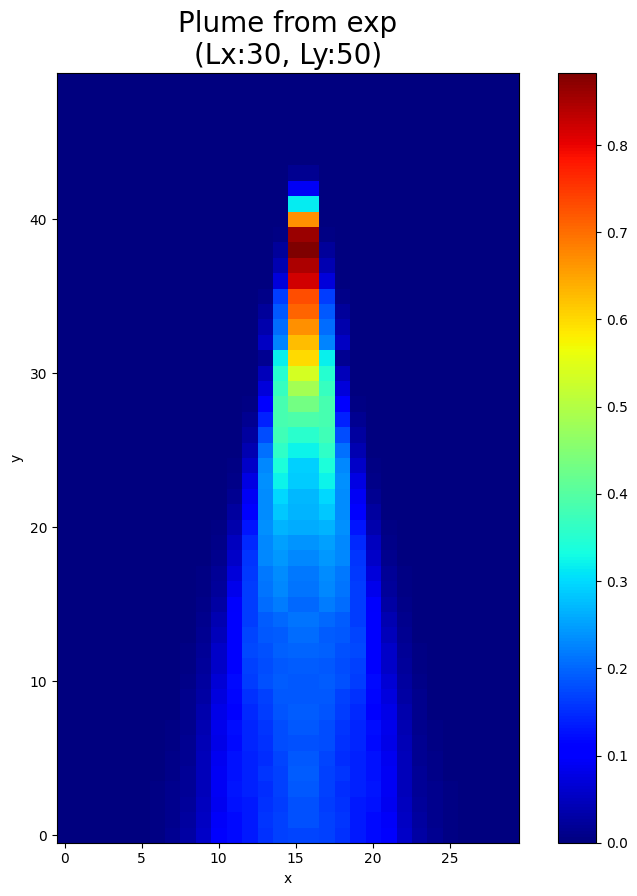

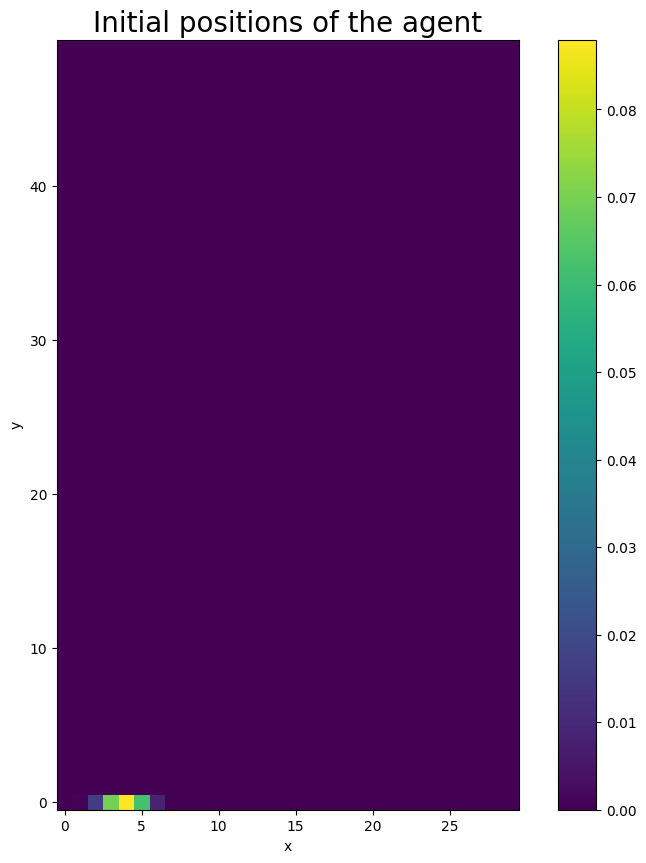

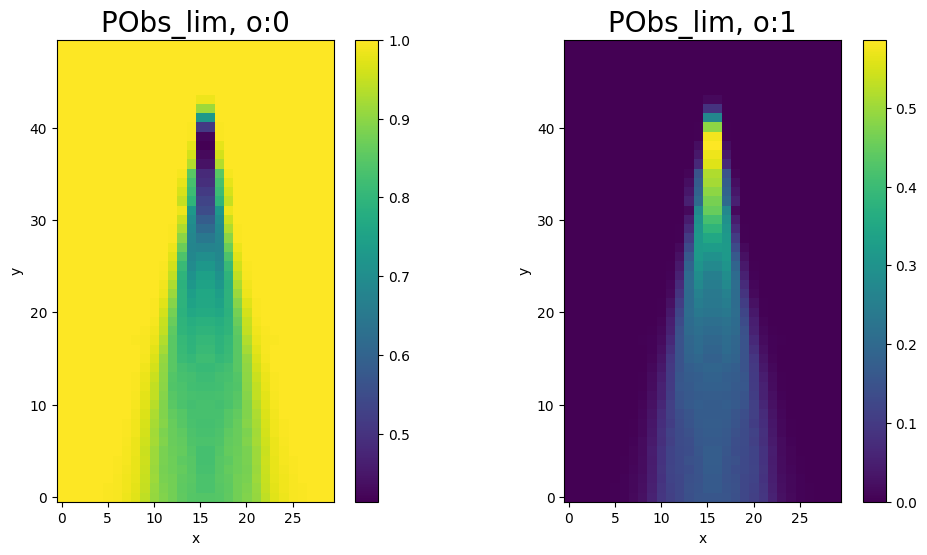

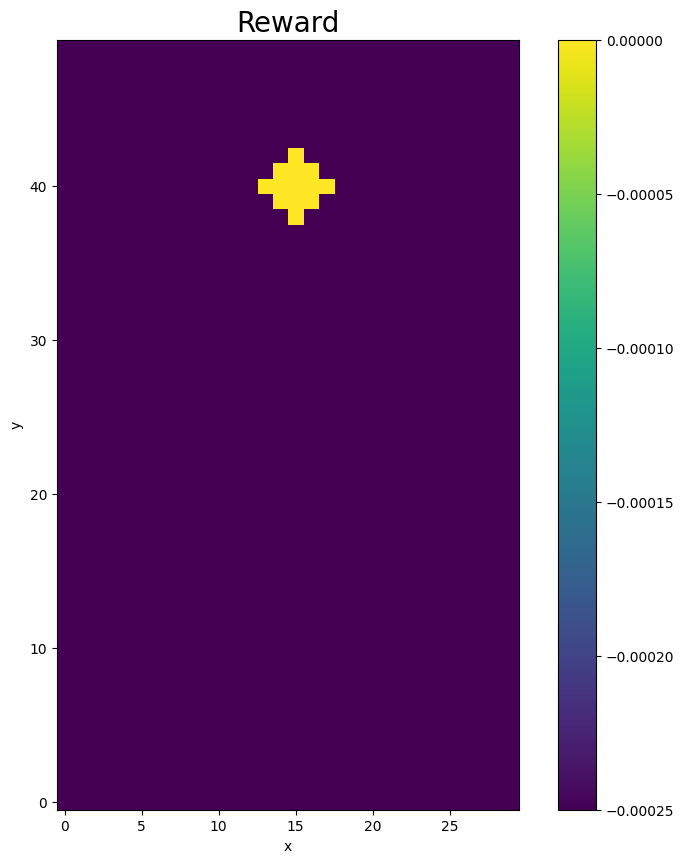

In [11]:
# Plot the plume 
fsc_visual.plot_plume(data, fsc, show=True, save=True, save_path=name_folder)
# Plot the initial positions of the agent
fsc_visual.plot_rho(rho0, fsc, show=True, save=True, save_path=name_folder)
# Plot the probability of the observations
fsc_visual.plot_PObs_lim(PObs_lim, fsc, show=True, save=True, save_path=name_folder)
# Plot the reward
fsc_visual.plot_reward(RR_np, fsc, show=True, save=True, save_path=name_folder)


## Initialize the optimization algorithm settings

In [12]:
# Set the learning rate schedule
if fsc.agent.lr_th == 'auto':
    # Learning rate schedule
    lr_val = fsc.agent.lr_val
    lr_time = fsc.agent.lr_time_frac

    lr_val = interpolate.interp1d(lr_time, lr_val, kind='linear',fill_value="extrapolate")
    lr_time = np.linspace(0.0, 1.0, num=fsc.optim.Ntot)
    lr_values = lr_val(lr_time)

else:
    lr_values = np.ones(fsc.optim.Ntot)*fsc.agent.lr_th

# Save the initial tolerance for the iterative method
init_direct = fsc.optim.init_direct
save_tol_eta = fsc.optim.tol_eta
save_tol_Q = fsc.optim.tol_Q

if init_direct != 0 and method == 'direct':
    fsc.optim.tol_eta = -1
    fsc.optim.tol_Q = -1

# set steps for choose iter or direct
method_select = method

# Convergence of the optimization
convergence = 0

# verbose for the optimization
verbose_eta = True

## Run the FSC model optimization

In [13]:
print('-'*77)
print('Starting optimization')
print('-'*77)
time_opt = time.time()
# Arrays to save the computation time
time_step = np.zeros((fsc.optim.Nprint,4))
# Save progress every 10% of the total iterations
save_progress = fsc.optim.Ntot // 10 or 1 


# Start for loop optimization
for t in range(fsc.optim.Ntot):

    # Timer
    timer_step = t % fsc.optim.Nprint
    time_step[timer_step,0] = time.time()

    if init_direct == t:
        fsc.optim.tol_eta = save_tol_eta
        fsc.optim.tol_Q = save_tol_Q

    if method_select == 'direct':
        # Direct linear system solution
        eta, T = utils.linear_solve_eta(fsc.agent, fsc.env, fsc.optim, eta, rho0, pi, PObs_lim, source_as_zero,solver=solver,verbose=verbose_eta)
        # time eta
        time_step[timer_step,1] = time.time()

        V, Q = utils.linear_solve_Q(fsc.agent, fsc.env, fsc.optim, T, V, RR_np, source_as_zero, solver=solver)
        # time Q
        time_step[timer_step,2] = time.time()

    elif method_select == 'iter':
        # Iterative solutions of linear system
        eta = utils.iterative_solve_eta(fsc.agent, fsc.env, fsc.optim, pi, PObs_lim, rho0, eta)
        # time eta
        time_step[timer_step,1] = time.time()

        Q = utils.iterative_solve_Q(fsc.agent, fsc.env, fsc.optim, pi, PObs_lim, RR, Q)
        # time Q
        time_step[timer_step,2] = time.time()

    # Check convergence 
    # --------------------------------------------------------
    value =  utils.get_value(Q, pi, PObs_lim, fsc.env.L, rho0)
    ratio_change[1] = ratio_change[0]
    ratio_change[0] = abs((value-oldvalue)/value)
    # ratio_change = abs((value-oldvalue)/value)
    ratio_change_avg = np.mean(ratio_change)

    oldvalue = value
    verbose_eta = False

    if (ratio_change_avg < fsc.optim.tol_conv) and ( fsc.optim.minimum_iter < t ):
        convergence = 1
    # --------------------------------------------------------
    
    # Gradient calculation
    grad = utils.find_grad(pi, Q, eta, fsc.env.L, PObs_lim)
    grad -= np.max(grad, axis=2, keepdims=True)

    # Reset value for new iteration afterwards
    lr_th = lr_values[t]
    
    # Apply gradient descent
    th += grad * lr_th / np.max(np.abs(grad)) # (t / Ntot + 0.5) #rescaled gradient
    th -= np.max(th, axis=2, keepdims=True)
    # th = np.clip(th, -20, 0)
    th = np.clip(th, -fsc.agent.AxM, 0)

    # Policy update
    pi = softmax(th, axis=2)
    # --------------------------------------------------------
    if t % save_progress == 0:
        np.savetxt(name_folder + '/file_theta.out', th.reshape(-1))
        np.savetxt(name_folder + '/file_V.out', V.reshape(-1))
        np.savetxt(name_folder + '/file_Q.out', Q.reshape(-1))
        np.savetxt(name_folder + '/file_eta.out', eta.reshape(-1))

    # Time step
    time_step[timer_step,3] = time.time() 

    # Print and check convergence
    if t % fsc.optim.Nprint == 0:

        print('lr_th: {:.5f}'.format(lr_th), end=' | ')
        if init_direct > t:
            print('direct method')
        else:
            print('mix methods', end=' | ')
            print('tol_eta: {:.2e} | tol_Q: {:.2e}'.format(fsc.optim.tol_eta, fsc.optim.tol_Q))

        print('step: {:5d} |  current value: {:.7f} | ratio value : {:.7f}'.format(t, value, ratio_change_avg), end=' | ')
        # Print times
        time_eta = np.sum(time_step[:,1] - time_step[:,0])
        print('time eta: {:10.3f}'.format(time_eta), end=' | ')
        time_Q = np.sum(time_step[:,2] - time_step[:,1])
        print('time Q: {:10.3f}'.format(time_Q), end=' || ')
        total_time = time_step[:,3] - time_step[:,0]
        # print('avg time: {:10.3f}'.format(np.mean(total_time)), end=' | ')
        # print('std dev: {:10.3f}'.format(np.std(total_time)), end=' | ')
        print('time total: {:10.3f}'.format(np.sum(total_time)),flush=True)

        print('-'*77)
        
        # Print values to file
        f.write('current value: {} @ time:{} \n'.format(value, t))
        f.flush()

    if convergence == 1:
        break

# End for loop optimization
# ----------------------------------------------------------------------------
if solver.use_petsc:
    solver.free_petsc(solver)


-----------------------------------------------------------------------------
Starting optimization
-----------------------------------------------------------------------------


T matrix info:
               Type of Tsm_sm_matrix: <class 'scipy.sparse._csr.csr_matrix'>
                 Tsm_sm_matrix shape: (6000, 6000)
number of non-zeros in Tsm_sm_matrix: 141408
number of     zeros in Tsm_sm_matrix: 35858592
               opacity of the matrix:  0.3928 %
           Sparse matrix memory size: 1.7208999999999999  MB
Theoretical dense matrix memory size: 288.0  MB
-----------------------------------------------------------------------------
lr_th: 0.01000 | direct method
step:     0 |  current value: -0.6840106 | ratio value : 1.0000000 | time eta:      7.082 | time Q:      2.817 || time total:     10.693
-----------------------------------------------------------------------------
lr_th: 0.01000 | mix methods | tol_eta: 1.00e-08 | tol_Q: 1.00e-08
step:  1000 |  current value: -0.0712815 | ratio value : 0.0013016 | time eta:    395.870 | time Q:     76.124 || time total:    477.121
-----------------------------------------------------------------------------
lr

## Save the results of the optimization

In [14]:
# final print
print('Create file theta')
np.savetxt(name_folder + '/file_theta.out', th.reshape(-1))
print('Create file Q')
np.savetxt(name_folder + '/file_Q.out', Q.reshape(-1))
print('Create file V')
np.savetxt(name_folder + '/file_V.out', V.reshape(-1))
print('Create file eta')
np.savetxt(name_folder + '/file_eta.out', eta.reshape(-1))
f.close()

if t < fsc.optim.Ntot:
    print('-'*77)
    print('converged at T = {} with value = {:.6f} and ratio change = {}'.format(t,value,ratio_change_avg))
    print('time total:{:10.3f}'.format(time.time()-time_opt))
    print('-'*77)
    print('theta: \n', th)
else:
    print('did not converged for {} runs and tolerance {}'.format(fsc.optim.Ntot, fsc.optim.tol_conv))
    print('current value: {} @ time:{} \n'.format(value, t))

Create file theta
Create file Q


Create file V
Create file eta
-----------------------------------------------------------------------------
converged at T = 9999 with value = -0.029839 and ratio change = 7.505030532329433e-06
time total:  2436.901
-----------------------------------------------------------------------------
theta: 
 [[[  0.      -24.      -18.92024 -18.05085  -5.84658  -0.34073 -15.41855 -24.      -24.      -22.18775 -24.       -5.88373 -24.      -24.      -24.      -24.      -24.      -11.51885 -24.      -24.      -24.      -22.65385 -24.       -2.88049]
  [ -2.98436  -9.41512  -4.39016  -9.48676   0.       -4.08203  -3.40677  -8.50986  -5.93062  -7.67895  -2.92653  -2.80915 -12.17089 -15.23034 -16.24655 -12.81909 -13.901    -7.74015 -20.5125  -21.32197 -24.      -16.1929  -24.      -11.62434]
  [ -3.2728   -3.57228  -2.08438  -3.37956  -0.61885  -0.17364  -4.25163  -2.88493  -1.61002  -4.98156  -0.76337  -1.95196  -5.31988  -1.11458  -0.72892  -5.24417  -1.37858  -3.80362  -5.5573    0.       -0.99

## Plot the results of the optimization ($\eta$, Q)

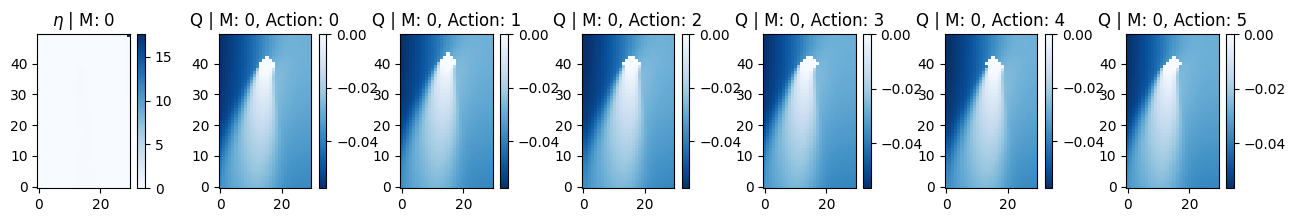

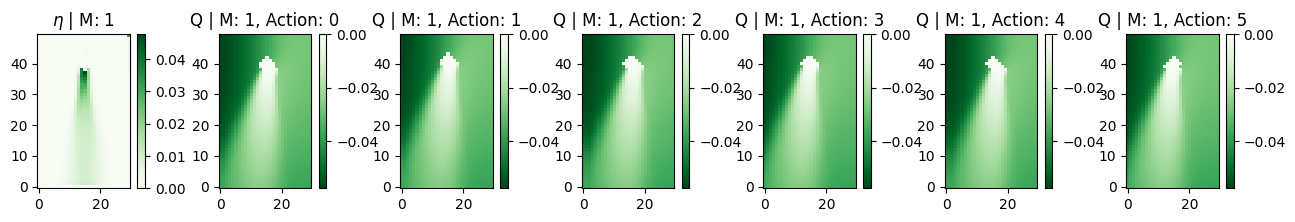

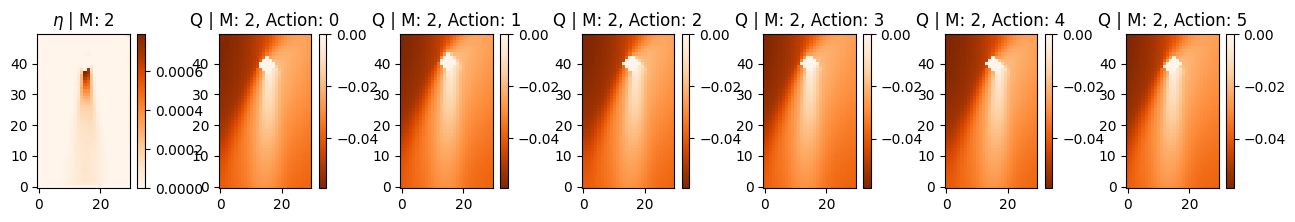

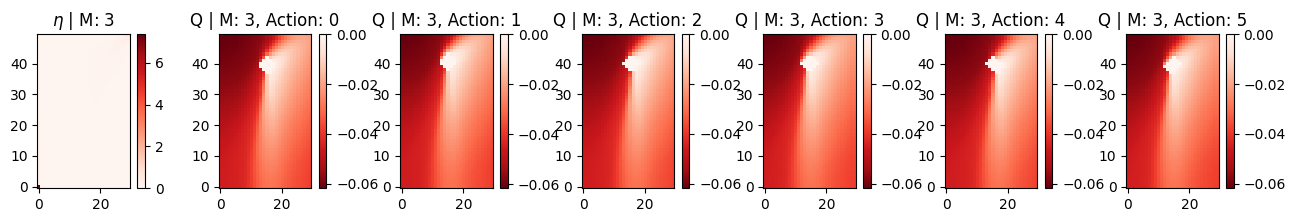

In [15]:
fsc_visual.plot_eta_Q(eta, Q, fsc, show=True, save=False, save_path=name_folder)

## Plot the policy of the optimized FSC model

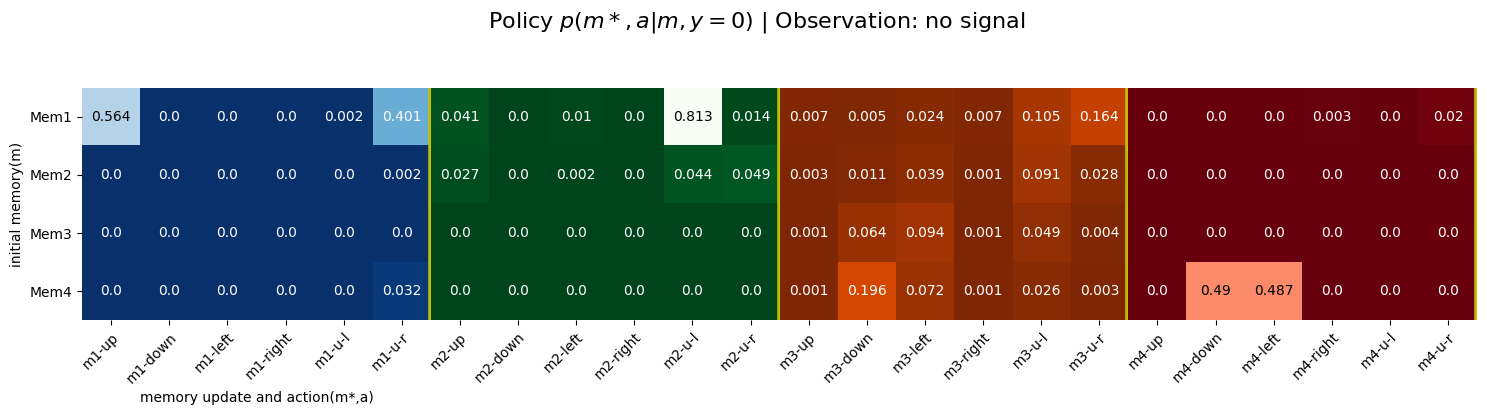

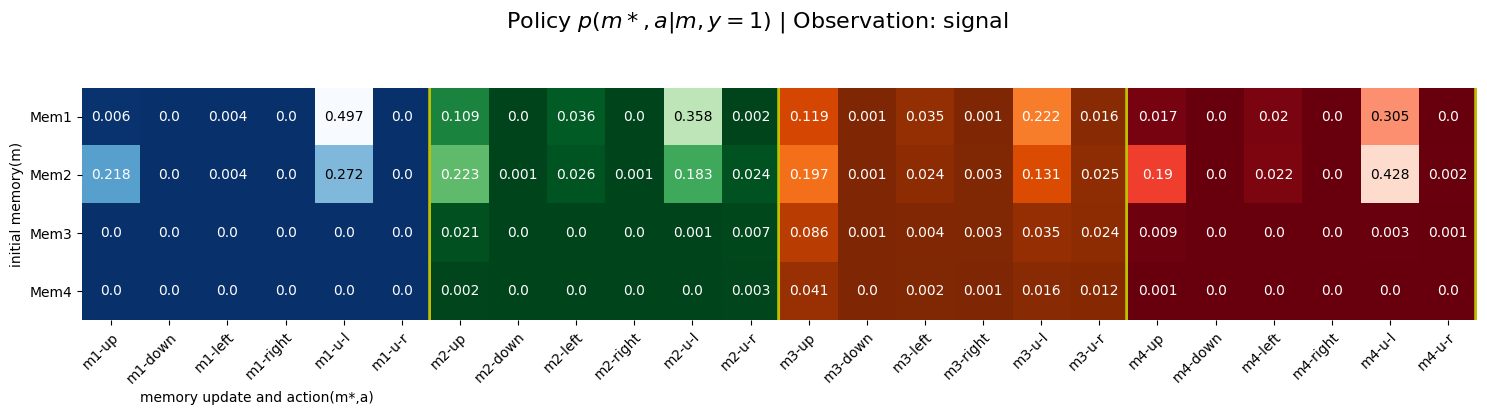

In [16]:
pi = softmax(th, axis=2)
obs_status = ['no signal','signal','differs from signal']
fsc_visual.plot_policy(pi, fsc, obs_status, show=True, save=True, save_path=name_folder)

## Sample the optimized trajectory with FSC model

  Value of the policy: -0.02983886490825982
Quality of the policy: 121.1572633359346
--------------------------------------------------


 20%|█▉        | 48/242 [00:00<00:00, 2439.14it/s]

Trajectory length: 48 | Success: 1


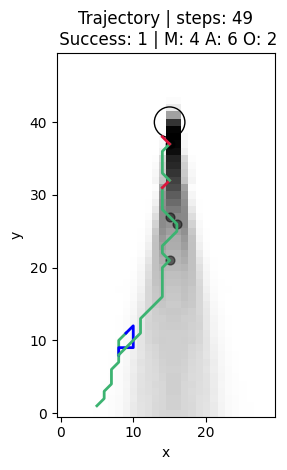

In [20]:
value =  utils.get_value(Q, pi, PObs_lim, fsc.env.L, rho0)
qlty_value = np.log(1+value)/np.log(fsc.agent.gamma)
print('  Value of the policy: {}'.format(value))
print('Quality of the policy: {}'.format(qlty_value))
print("-"*50)

# Compute the trajectory of the agent
max_trajectory_length = int(qlty_value) * 2

trj, result, trj_steps = utils.single_traj_obs(pi, fsc.env.Lx, fsc.env.Ly, fsc.env.Lx0, fsc.env.Ly0, fsc.env.find_range, max_trajectory_length, PObs_lim, rho0, fsc.agent.act_hdl,progress_bar=True)

print('Trajectory length: {} | Success: {}'.format(trj_steps, result))

# Plot the trajectory of the agent
fsc_visual.plot_trajectory(trj, result, PObs_lim, fsc, show=True, save=False, save_path=name_folder)

## Validate the optimized FSC model

Number episodes: 1000, max Time steps: 605


Success Rate: 100.000%: 100%|██████████| 1000/1000 [00:10<00:00, 98.93it/s] 


Success Rate: 100.000%
Time elapsed: 10.126 s
Plotting search time distribution...


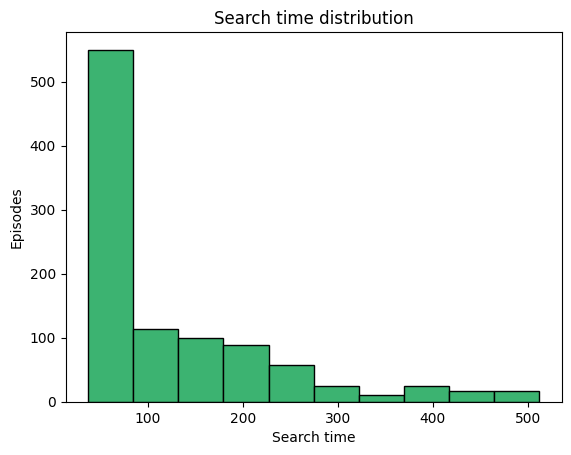

In [18]:
time_start = time.time()
Nep = 1000   #number of trajectories to reproduce
maxT = int(qlty_value) * 5

print('Number episodes: {}, max Time steps: {}'.format(Nep, maxT))

# av_ret, Total_trj = search_time_statistic(Nep,maxT,pi, fsc.env.Lx, fsc.env.Ly, fsc.env.Lx0, fsc.env.Ly0, fsc.env.find_range, PObs_lim, rho0, fsc.agent.act_hdl)
av_ret, Total_trj = utils.compute_trajectory_future(pi, fsc.env.Lx, fsc.env.Ly, fsc.env.Lx0, fsc.env.Ly0, fsc.env.find_range, maxT, PObs_lim, rho0, fsc.agent.act_hdl, Nep=Nep)

time_end = time.time()
print('Success Rate: {:.3f}%'.format(100*av_ret / Nep))
print('Time elapsed: {:.3f} s'.format(time_end - time_start))

# Plot the distribution of search times
print('Plotting search time distribution...')
fig, ax = plt.subplots()
ax.hist(Total_trj, bins = 10, color = 'mediumseagreen', edgecolor = 'black')
plt.title('Search time distribution')
plt.xlabel('Search time')
plt.ylabel('Episodes')
# plt.savefig(directory+'/search_time_distribution.png', bbox_inches = 'tight', pad_inches = 0.1)
plt.show()
